### Reference
https://github.com/Kaustubh-Tambe/BBC-News_Topic-Modelling/blob/main/Notebook/BBC_News_Topic_Modelling_Project.ipynb

# Install Libraries

In [1]:
# pip install gensim
# conda install -c anaconda gensim
!pip3 install gensim

Defaulting to user installation because normal site-packages is not writeable


In [2]:
pip install spacy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pyLDAvis

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip3 install wheel
!pip3 install pandas

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [5]:
pip install nltk

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Genism
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Spacy for Lemmatization
import spacy

# Plotting
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/storage/home/hcocice1/jpark3141/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Downloading and preparing stopwords from NLTK & extended_stopwords.txt

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /storage/home/hcocice1/jpark3141/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# add more stopwords
file = open("./extended_stopwords.txt", "r")
stop_words.extend([line.strip() for line in file.readlines()])
file.close()

# Converting it to DF

In [10]:
%ls

2016-01-posts.csv
cuda-repo-rhel8-11-8-local-11.8.0_520.61.05-1.x86_64.rpm
Cusim_Word2Vec.ipynb
divide_submissions.ipynb
extended_stopwords.txt
lda - Copy.ipynb
LDA_CUSIM.ipynb
NVIDIA Nsight Compute/
requirements
res/
submissions.csv
subreddit_file/
subreddit_list.csv


In [77]:
# importing the required modules
import glob
import pandas as pd
  
# specifying the path to csv files
#path = "subreddit_file"
  
# csv files in the path
#files = glob.glob(path + "/*.csv")
  
#df = pd.DataFrame()
  
# checking all the csv files in the 
# specified path
#for filename in files:
    
    # reading content of csv file
    # content.append(filename)
#    df = pd.read_csv(filename, index_col=None)
  
data = pd.read_csv("./subreddit_file/subreddit_The_Donald.csv")


In [78]:
data.info() #3002067 entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4810 entries, 0 to 4809
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   subreddit_id  4810 non-null   object
 1   selftext      4810 non-null   object
 2   author        4810 non-null   object
 3   over_18       4810 non-null   bool  
 4   ups           4810 non-null   int64 
 5   created_utc   4810 non-null   int64 
 6   score         4810 non-null   int64 
 7   downs         4810 non-null   int64 
 8   title         4810 non-null   object
 9   num_comments  4810 non-null   int64 
 10  subreddit     4810 non-null   object
 11  quarantine    4810 non-null   bool  
dtypes: bool(2), int64(5), object(5)
memory usage: 385.3+ KB


In [79]:
data.head()

,subreddit_id,selftext,author,over_18,ups,created_utc,score,downs,title,num_comments,subreddit,quarantine
0,t5_38unr,[deleted],[deleted],False,1,1449838705,1,0,Livestream: Donald Trump Campaign Rally Event ...,0,The_Donald,False
1,t5_38unr,[deleted],[deleted],False,2,1451016217,2,0,Can anyone link me to Trump's first rally?,2,The_Donald,False
2,t5_38unr,[deleted],[deleted],False,14,1451840538,14,0,Would anyone be willing to chip in to get a sp...,12,The_Donald,False
3,t5_38unr,[deleted],[deleted],False,0,1452861365,0,0,"Wow, I have never seen a cat behave like this....",0,The_Donald,False
4,t5_38unr,[deleted],[deleted],False,10,1452903094,10,0,Trump's List,5,The_Donald,False


# Preprocessing

In [80]:
print(data.isnull().sum()) # selftext has 1689024 Nan

subreddit_id    0
selftext        0
author          0
over_18         0
ups             0
created_utc     0
score           0
downs           0
title           0
num_comments    0
subreddit       0
quarantine      0
dtype: int64


In [81]:
# drop [removed] AND [deleted]
# data.astype({'selftext':'string'}).dtypes
# data = data[data["selftext"].str.contains("[removed]|[deleted]|deleted|removed") == False]

#identify partial string to look for
discard = ["removed", "deleted"]
#drop rows that contain the partial string "Wes" in the conference column
data = data[~data['selftext'].str.contains('|'.join(discard))]

# delete Nan from selftext
data = data.dropna(axis=0)

data.astype({'selftext':'string'}).dtypes
data.info()

# delete [removed]
print(len(data))
#count = [c for c in updated_df['selftext'] if "[removed]" in c]
#print(len(count)) # 15552 rows of [removed]
#filtered_df = updated_df[updated_df['selftext'].str.contains("[removed]") == False]
#wrong = updated_df[updated_df['selftext'].str.contains("[removed]") == True]
#print(len(filtered_df))
#print(len(wrong))
#df['selftex'] = df['selftext'].map(lambda x: x.lower())
#filtered_df.head()

# now reduced to "1313021"

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 7 to 4773
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   subreddit_id  361 non-null    object
 1   selftext      361 non-null    object
 2   author        361 non-null    object
 3   over_18       361 non-null    bool  
 4   ups           361 non-null    int64 
 5   created_utc   361 non-null    int64 
 6   score         361 non-null    int64 
 7   downs         361 non-null    int64 
 8   title         361 non-null    object
 9   num_comments  361 non-null    int64 
 10  subreddit     361 non-null    object
 11  quarantine    361 non-null    bool  
dtypes: bool(2), int64(5), object(5)
memory usage: 31.7+ KB
361


In [82]:
data['selftext'].map(lambda x: x.lower())

7       - https://vimeo.com/153149804\n- https://www.y...
19                           juan by juan. (not my joke).
45                                                      ?
75      i'm **done** with faux news, and you shoud be ...
84                                               #bigddon
                              ...                        
4738                                  high energy af moab
4745                                          that is all
4761                        "stop being poor." - ayn rand
4771    http://dailycaller.com/2017/03/26/exclusive-jo...
4773    bill nye the rapist guy\n\n\nkiddssss rullleee...
Name: selftext, Length: 361, dtype: object

In [108]:
# converting DataFrame column into List
data = data['selftext'].tolist()

# Remove url
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
# remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


#pprint(data[:1])
print(data[0])

TypeError: list indices must be integers or slices, not str

In [84]:
# Tokenize the Data
def sent_to_words(sents, deacc=True):
    for sentence in sents:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))

data_words = list(sent_to_words(data))

In [85]:
# Defining the Bigram and Trigram Model
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])


['https', 'vimeo', 'com', 'https', 'www', 'youtube', 'com', 'watch', 'pg', 'rjzyo', 'https', 'www', 'youtube', 'com', 'watch', 'cr_fiq', 'dxhu', 'https', 'www', 'youtube', 'com', 'watch', 'lmwoorwduug', 'https', 'www', 'youtube', 'com', 'watch', 'wykamqvxg', 'https', 'www', 'youtube', 'com', 'watch', 'pkviapyokpk', 'https', 'www', 'youtube', 'com', 'watch', 'ez', 'xdwgt', 'ls', 'https', 'www', 'youtube', 'com', 'watch', 'cmslyk_jdhk', 'https', 'www', 'youtube', 'com', 'watch', 'gktlnwgzz', 'https', 'www', 'youtube', 'com', 'watch', 'zfqdwvdrq', 'https', 'www', 'youtube', 'com', 'watch', 'tai', 'ziy']


In [86]:
# create functions for removing stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

#creating fuctions for making bigram
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

#creating fuctions for making trigram
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#creating fuctions for Lemmitization
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #corpus will have the words that belong to only these part of speech
    
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [87]:
!python3 -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 12.8 MB 3.7 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [88]:
#Using all the Functions Created for Preprocessing
data_words_nostops = remove_stopwords(data_words)

In [89]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [90]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [91]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['dxhu', 'https', 'youtube', 'https', 'youtube', 'wykamqvxg', 'https', 'youtube', 'https', 'youtube', 'watch', 'https', 'youtube', 'watch', 'https', 'youtube', 'youtube', 'watch', 'tai', 'ziy']]


In [92]:
# Again Removing Stop Words
# sometimes Lemma can be equivalent to the stopwords... 
data_words_nostops = remove_stopwords(data_lemmatized)

In [93]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Use LDA for Topic Modeling

In [94]:
#here we are trying to get the optimal model according to the Coherence score(meseaure of Separability) to figure out no of topics ..
def tune_model(dictionary, corpus, texts, limit, start, step):
    
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True,
                                           )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(round(coherencemodel.get_coherence(),3))

    return model_list, coherence_values

In [95]:
# Can take a long time to run
from tqdm import tqdm
model_list, coherence_values = tune_model(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=10, step=1)

  0%|          | 0/8 [00:00<?, ?it/s]/storage/home/hcocice1/jpark3141/.local/lib/python3.9/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/storage/home/hcocice1/jpark3141/.local/lib/python3.9/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))
100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


# Coherence Score

## Plotting Line Graph for Coherence Score

In [96]:
print(coherence_values)

[nan, nan, nan, nan, nan, nan, nan, nan]


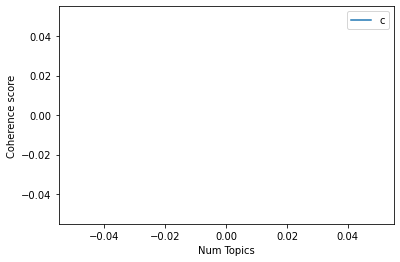

In [97]:
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Print Coherence Scores

In [98]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of nan
Num Topics = 3  has Coherence Value of nan
Num Topics = 4  has Coherence Value of nan
Num Topics = 5  has Coherence Value of nan
Num Topics = 6  has Coherence Value of nan
Num Topics = 7  has Coherence Value of nan
Num Topics = 8  has Coherence Value of nan
Num Topics = 9  has Coherence Value of nan


### Should Figure out our maximum Coherence Value!! -> LDA Model

In [99]:
#here we knew that the coherence score is maximum for 6 topics so that will become our optimal model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [100]:
#getting dominant words for each topics 
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.060*"maga" + 0.034*"ifififif" + 0.029*"net" + 0.025*"file" + 0.025*"png" '
  '+ 0.016*"medium" + 0.014*"upload" + 0.014*"link" + 0.010*"berkeley" + '
  '0.010*"sadddddd"'),
 (1,
  '0.019*"reform" + 0.019*"article" + 0.017*"happen" + 0.016*"politic" + '
  '0.015*"train" + 0.015*"shame" + 0.015*"mod" + 0.015*"jpg" + 0.013*"call" + '
  '0.012*"prison"'),
 (2,
  '0.041*"http" + 0.012*"meme" + 0.011*"comment" + 0.011*"source" + '
  '0.011*"reddit" + 0.009*"thehill" + 0.009*"election" + 0.008*"trump" + '
  '0.008*"day" + 0.008*"fyi"'),
 (3,
  '0.078*"trump" + 0.021*"org" + 0.020*"wikileak" + 0.018*"cuck" + '
  '0.016*"emperor" + 0.015*"podesta" + 0.014*"confirm" + 0.013*"email" + '
  '0.012*"donate" + 0.011*"emailid"'),
 (4,
  '0.066*"btfo" + 0.049*"amp" + 0.023*"rapist" + 0.020*"people" + '
  '0.019*"centipede" + 0.017*"love" + 0.016*"win" + 0.016*"brake" + '
  '0.013*"absolutely" + 0.010*"wall"'),
 (5,
  '0.123*"https" + 0.049*"watch" + 0.035*"youtube" + 0.034*"energy" + '
  '0.0

# Result

## Cluster topics and see the dominant words in graphics

In [101]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

/storage/home/hcocice1/jpark3141/.local/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/storage/home/hcocice1/jpark3141/.local/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/storage/home/hcocice1/jpark3141/.local/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/storage/home/hcocice1/jpark3141/.local/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp imp

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.001804 -0.154094       1        1  28.586397
4      0.098986  0.145355       2        1  20.856004
5     -0.199017  0.063078       3        1  15.752435
3      0.032221 -0.026065       4        1  12.163971
0      0.040830 -0.000302       5        1  11.953103
1      0.025177 -0.027973       6        1  10.688090, topic_info=         Term       Freq      Total Category  logprob  loglift
1       https  24.000000  24.000000  Default  30.0000  30.0000
189      btfo  16.000000  16.000000  Default  29.0000  29.0000
11      trump  13.000000  13.000000  Default  28.0000  28.0000
71       maga   8.000000   8.000000  Default  27.0000  27.0000
232       amp  12.000000  12.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
636       ssf   1.214828   1.770390   Topic6  -4.5967   1.8594
148      good   1.209120   1.764078   Topic6  -4.6014   1.8583
22    politic   1.978418   2.960944   Topic6  -4.1090   1.8328
391      call   1.583496   3.627921   Topic6  -4.3316   1.4070
20   election   1.470232   4.689442   Topic6  -4.4059   1.0761

[230 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
203       2  0.865486    absolutely
606       5  0.515794          acce
624       6  0.564903    accomplish
607       5  0.515794            ad
232       2  0.994034           amp
...     ...       ...           ...
231       2  0.917897           win
614       5  0.515795     wordpress
634       3  0.944203         worth
623       4  0.513133  yeeeaaaahhhh
5         3  0.883992       youtube

[213 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 6, 4, 1, 2])

In [102]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable


In [103]:
#visualization libraries 
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

In [104]:
#Creating Word Cloud
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

In [105]:
#preparation for wordcloud
topics = lda_model.show_topics(formatted=False)
topic_words = dict(topics)

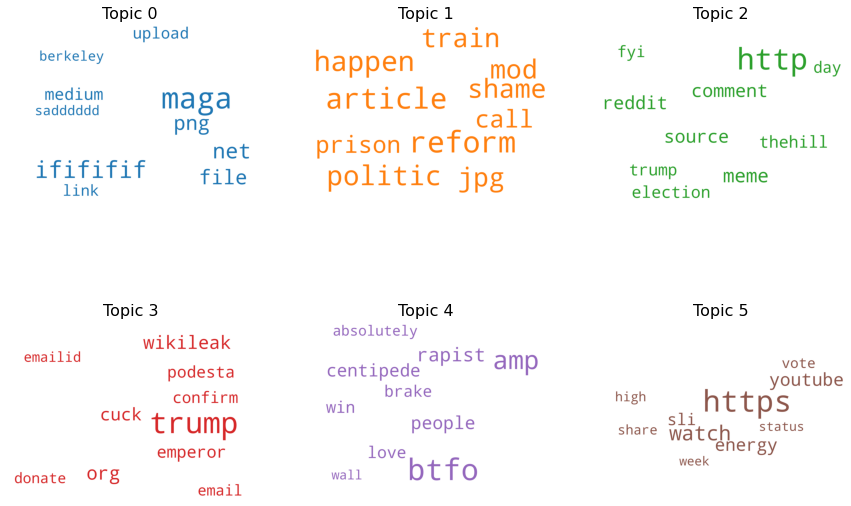

In [106]:
fig, axes = plt.subplots(2,3 , figsize=(15,10), sharex=True, sharey=True)
#fig.delaxes(ax[1,1])

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')